### Observe the response from simple router(chain_agents.ipynb), where the graph uses the tool and returns a ToolMessage instead of an AI message

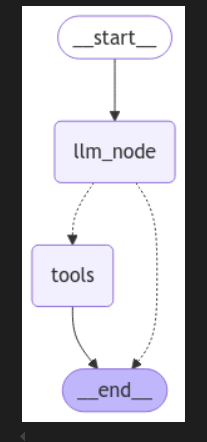

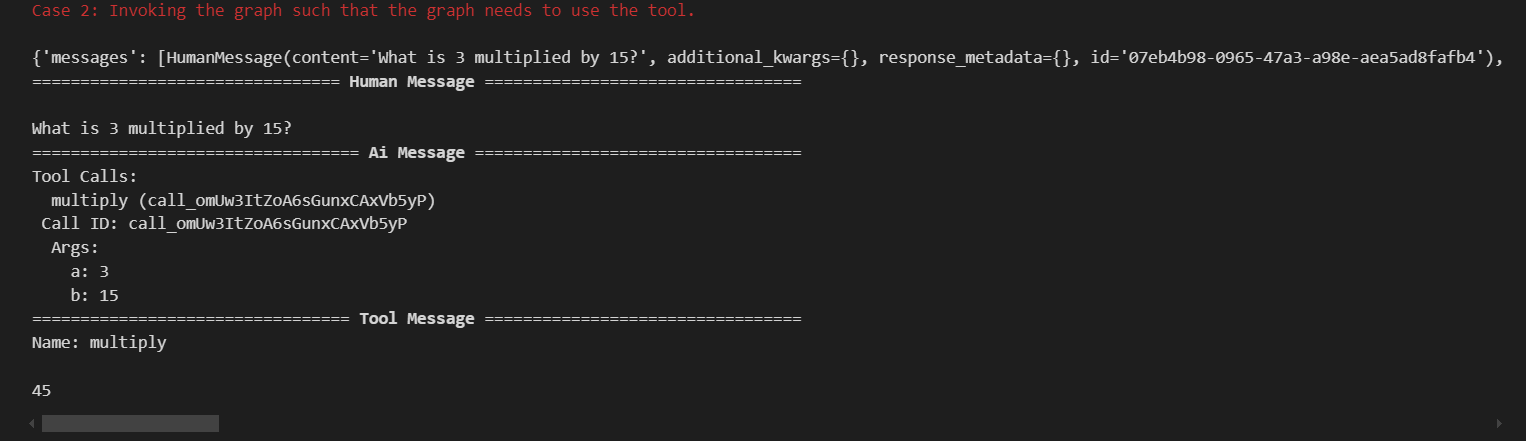

#### Can we pass the ToolMessage back to the Model? If we can, then the model will have 2 options
##### 1) Call a(this one or different) tool again
##### 2) Respond directly to the query
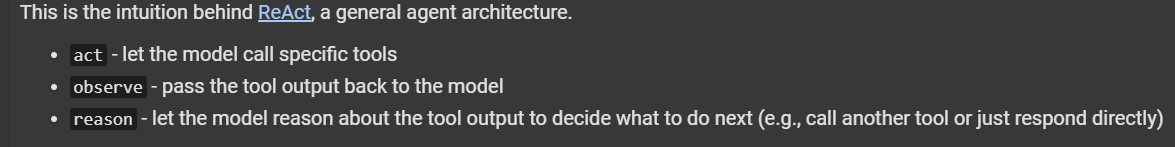

In [2]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

def multiply(a:int, b:int) -> int:
    """
    Multiply a and b
    Args:
        a: first int
        b: Second int
    
    """
    return a * b

def add(a:int, b:int) -> int:
    """
    Add a and b
    Args:
        a: first int
        b: Second int
    
    """
    return a + b

def divide(a:int, b:int) -> float:
    """
    Divide a and b
    Args:
        a: first int
        b: Second int
    
    """
    return a / b

llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model="gpt-3.5-turbo",temperature=0.3)
tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)



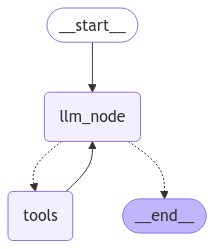

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display


system_message = SystemMessage(content="You are a helpful assistant capable of doing math.")

# Defining the node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message]+state["messages"])]}


graph_builder = StateGraph(MessagesState)

graph_builder.add_node("llm_node", assistant)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges("llm_node",tools_condition)
graph_builder.add_edge("tools", "llm_node")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [8]:
from pprint import pprint
my_messages = HumanMessage(content="Add 3 and 4.")

response = graph.invoke({"messages": [my_messages]})
print(response)

for message in response["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='c63f7a1b-e951-43d5-8a02-894263584f27'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Gnb8i4zfqkGXwMxPlvc8HyxC', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 154, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-097a1cc7-fe8b-489a-8eb4-a8e4420ca712-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_Gnb8i4zfqkGXwMxPlvc8HyxC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 18, 'total_tokens': 172,

In [10]:
my_messages2 = HumanMessage(content="calculate the sum of 3 and 4. Then multiply that by 5. ")

response2 = graph.invoke({"messages": [my_messages2]})
print(response2)

for message in response2["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='calculate the sum of 3 and 4. Then multiply that by 5. ', additional_kwargs={}, response_metadata={}, id='4c305b83-4e63-4f8f-aa13-0e475fa3c30a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B3iYAOkMn5zhrfEtcd5Kk3SI', 'function': {'arguments': '{"a": 3, "b": 4}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_tCeMpH46hECW4s6qnxo5n6OI', 'function': {'arguments': '{"a": 7, "b": 5}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 165, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96292bdd-435b-41f7-b678-f344281b86f6-0', tool_calls=[{'name':

#### Now lets verify if state can be maintained across 2 different graph invocations

In [ ]:
my_messages3 = HumanMessage(content="Add 2 and 3.")

response3 = graph.invoke({"messages": [my_messages3]})
print(response3)

for message in response3["messages"]:
    message.pretty_print()

"""
Separating 2 difefrent graph invocations and verify if the graph is abel to retain the result of addition in previous step while 
performing multiplication in the next step.

Step 1: Add 2 and 3
Expected out put of this step: 5

Step 2: Multiply that(5) with 10
Expected final output: 50

"""

my_messages4 = HumanMessage(content="Multiply that with 10.")

response4 = graph.invoke({"messages": [my_messages4]})
print(response4)

for message in response4["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='Add 2 and 3.', additional_kwargs={}, response_metadata={}, id='4a2269c2-1cec-4c3a-a4d2-db9f656a463e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H7C8ZpkUnFURXLsCujjAFWkb', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 154, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bccb438a-c229-411b-9e7c-25eac47844d8-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_H7C8ZpkUnFURXLsCujjAFWkb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 18, 'total_tokens': 172,

#### Observe here that we are not able to get proper result as our graph does not have the memory of the result(5) from Step 1 and we can say that the state is not maintained across different graph invocations. Hence we need some kind of memory to retain teh menory of 5 from step 1.

#### We can use persistence to address this.

LangGraph uses checkpointer to automatically save the graph state after each step. Here, we will be using the easiest checkpointers(MemorySaver), an in-memory key-value store for Graph state. We will just compile the graph with a checkpointer, and our graph will have memory that can be accesses using a thread_id, which will store our collection of graph states.

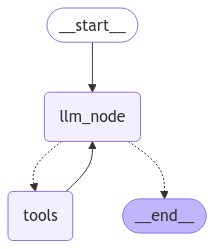

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

system_message = SystemMessage(content="You are a helpful assistant capable of doing math.")

# Defining the node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message]+state["messages"])]}


graph_builder = StateGraph(MessagesState)

graph_builder.add_node("llm_node", assistant)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges("llm_node",tools_condition)
graph_builder.add_edge("tools", "llm_node")

# Adding memory to the equation
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [14]:
human_message = HumanMessage(content="Add 15 and 9")

chat_1 = {"configurable": {"thread_id":"chat1"}}

# passing chat_1 as the thread_id 
response = graph.invoke({"messages": [human_message]},config=chat_1)

for message in response["messages"]:
    message.pretty_print()

"""
Step 1: Add 15 and 9
Expected out put of this step: 24

Step 2: Divide that(24) by 2.
Expected final output: 12

"""

my_messages4 = HumanMessage(content="Divide that by 2.")

response4 = graph.invoke({"messages": [my_messages4]}, config=chat_1)
print(response4)

for message in response4["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 15 and 9
================================== Ai Message ==================================
Tool Calls:
  add (call_K6PVgsVBtvOAoGZE6rDScl89)
 Call ID: call_K6PVgsVBtvOAoGZE6rDScl89
  Args:
    a: 15
    b: 9
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

The sum of 15 and 9 is 24.
{'messages': [HumanMessage(content='Add 15 and 9', additional_kwargs={}, response_metadata={}, id='b7d7b7b3-4289-4cb0-b16e-bde99758244b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K6PVgsVBtvOAoGZE6rDScl89', 'function': {'arguments': '{"a":15,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 153, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'a